# Cluster neighborhoods and embeddings

To further investigate the neuronal diversity within each major brain structure, [Yao et al](https://doi.org/10.1101/2023.03.06.531121) created concept of cell types "neighborhoods" or groups and use them for visualization and analysis. For each neighborhood, they genereated re-embedded UMAPS to reveal fine-grained relationships between neuronal types within and between brain regions.

In [1]:
import os
import pandas as pd
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import requests
import pathlib

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
download_base = '../../abc_download_root'

url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/releases/20230630/manifest.json'
manifest = json.loads(requests.get(url).text)

if 0 :
    file = os.path.join( download_base, 'releases', '20230630', 'manifest.json')
    with open(file,'rb') as f :
        manifest = json.load(f)
    

In [3]:
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['WMB-neighborhoods']['directories']['metadata']['relative_path'], 
                              'views')
view_directory = pathlib.Path( view_directory )
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

## Data Overview

### Cluster groups

Each cell type neighborhood is represented as a cluster group. Each row of the dataframe represnts a ***cluster group***. Each *cluster* has a *label* (human readable string that is unique in the database), *name*, *description* and the *number of clusters* that has been grouped together.

In [4]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
groups = pd.read_csv(file)
print("number of groups:",len(groups))
groups.set_index('label',inplace=True)
groups

number of groups: 18


,name,description,group_type,number_of_clusters
label,,,,
CCN20230504_CNU-HYa-GABA,CNU-HYa-GABA,The hypothalamus and extended amygdala (HY-EA)...,cell type neighborhood,381
CCN20230504_HY-GABA,HY-GABA,The hypothalamus and extended amygdala (HY-EA)...,cell type neighborhood,420
CCN20230504_HY-EA-Glut,HY-EA-Glut,The hypothalamus and extended amygdala (HY-EA)...,cell type neighborhood,587
CCN20230504_HY-EA,HY-EA,The hypothalamus and extended amygdala (HY-EA)...,cell type neighborhood,1388
CCN20230504_Pallium-Glut,Pallium-Glut,Glutamatergic neurons from isocortex and hippo...,cell type neighborhood,501
CCN20230504_NP-CT-L6b-Glut,NP-CT-L6b-Glut,"Glutamatergic, NP, CT, and L6b neurons in isoc...",cell type neighborhood,83
CCN20230504_IT-ET-Glut,IT-ET-Glut,"Glutamatergic, IT and ET neurons in isocortex",cell type neighborhood,402
CCN20230504_NN-IMN-GC,NN-IMN-GC,"Non-neuronal cells, immature neurons, dentate ...",cell type neighborhood,245
CCN20230504_Subpallium-GABA,Subpallium-GABA,Telencephalic GABAergic neurons. Neighborhood ...,cell type neighborhood,1051


### Cluster group membership

The association between a cluster and cluster group is represented as a cluster group membership.

In [5]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file)
group_membership.head(5)

,cluster_label,cluster_group_label,cluster_alias,cluster_group_name
0,CS20230305_0128,CCN20230504_IT-ET-Glut,128,IT-ET-Glut
1,CS20230305_0128,CCN20230504_Pallium-Glut,128,Pallium-Glut
2,CS20230305_0128,CCN20230504_WholeBrain,128,WholeBrain
3,CS20230305_0129,CCN20230504_IT-ET-Glut,129,IT-ET-Glut
4,CS20230305_0129,CCN20230504_Pallium-Glut,129,Pallium-Glut


### Dimension reductions

Principal component analysis (PCA) was first preformed on the gene expression matrix.
The top 100 PCs were selected and used to create a 2D UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction) for all cells in the datasets. Further, for each neighborhood or cluster group, an additional specific 2D UMAP or embedding is created.

Each row of the ***dimension reduction*** dataframe represents on embedding. Each row of the dataframe represnts an embedding. Each *dimension reduction* has a *label* (human readable string that is unique in the database), *name*, *description*, the *number of cells* in the embedding and the label of the associated *cluster group*.

In [6]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['dimension_reduction']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
maps = pd.read_csv(file)
print("number of maps:",len(maps))
maps

number of maps: 18


,label,name,description,number_of_cells,cluster_group_label
0,UMAP20230507-CNU-HYa-GABA,CNU-HYa-GABA,The hypothalamus and extended amygdala (HY-EA)...,77186,CCN20230504_CNU-HYa-GABA
1,UMAP20230507-HY-GABA,HY-GABA,The hypothalamus and extended amygdala (HY-EA)...,90331,CCN20230504_HY-GABA
2,UMAP20230507-HY-EA-Glut,HY-EA-Glut,The hypothalamus and extended amygdala (HY-EA)...,126678,CCN20230504_HY-EA-Glut
3,UMAP20230507-HY-EA,HY-EA,The hypothalamus and extended amygdala (HY-EA)...,294195,CCN20230504_HY-EA
4,UMAP20230507-Pallium-Glut,Pallium-Glut,Glutamatergic neurons from isocortex and hippo...,1494964,CCN20230504_Pallium-Glut
5,UMAP20230507-NP-CT-L6b-Glut,NP-CT-L6b-Glut,"Glutamatergic, NP, CT, and L6b neurons in isoc...",311327,CCN20230504_NP-CT-L6b-Glut
6,UMAP20230507-IT-ET-Glut,IT-ET-Glut,"Glutamatergic, IT and ET neurons in isocortex",1098949,CCN20230504_IT-ET-Glut
7,UMAP20230507-NN-IMN-GC,NN-IMN-GC,"Non-neuronal cells, immature neurons, dentate ...",1428872,CCN20230504_NN-IMN-GC
8,UMAP20230507-Subpallium-GABA,Subpallium-GABA,Telencephalic GABAergic neurons. Neighborhood ...,615417,CCN20230504_Subpallium-GABA
9,UMAP20230507-CTX-CGE-MGE-GABA,CTX-CGE-MGE-GABA,CGE- and MGE-derived GABAergic neurons in isoc...,262831,CCN20230504_CTX-CGE-MGE-GABA


## Example use cases

### Cluster group membership pivot table

To support analysis and visualization by cluster group in later tutorials, we create a pivot table using pandas groupby fuunction. Each row of the resulting dataframe represents a cluster, each column represents cluster group and the value in the table is a boolean specifying if the cluster is a member of the cluster group.

In [7]:
pivot = group_membership.groupby(['cluster_alias','cluster_group_name'])['cluster_group_name'].first().unstack()
pivot = pivot.notna()
pivot

cluster_group_name,CNU-HYa-GABA,CTX-CGE-MGE-GABA,HY-EA,HY-EA-Glut,HY-GABA,IT-ET-Glut,MB,MB-HB-CB,MB-HB-CB-GABA,MB-HB-CB-Glut,MB-PONS,NN-IMN-GC,NP-CT-L6b-Glut,Other-Sub-GABA,Pallium-Glut,Subpallium-GABA,TH-EPI-Glut,WholeBrain
cluster_alias,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
5,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5406,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,True
5407,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,True
5408,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,True


For convenience, we can cache this view for later reuse.

In [8]:
if cache_views :
    
    file = os.path.join( view_directory, 'cluster_group_membership_pivoted.csv')
    pivot.to_csv( file )

### Visualize a cluster group in whole brain and neighborhood embeddings

In this example, we visualize cluster group "CCN20230504_HY-EA" in context the whole brain UMAP and specific "HY-EA" UMAP.

First step is to read in 10x cell metadata with annotation dataframe.

In [9]:
metadata = manifest['file_listing']['WMB-10X']['metadata']
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cell = pd.read_csv(file,dtype={"neurotransmitter":str})
cell.set_index('cell_label',inplace=True)

We join with cluster membership pivot table to get cell to cluster group member. For convenience, we can cache this view for later reuse.

In [10]:
joined_10x = cell.join(pivot,on='cluster_alias')

if cache_views :
    
    file = os.path.join( view_directory, '10x_cell_metadata_with_group_membership.csv')
    joined_10x.to_csv( file )

We defined a helper function to plot a UMAP using matplotlib scatter function.

In [11]:
def plot_umap( xx, yy, cc=None, val=None, fig_width = 8, fig_height = 8, cmap=None ) :
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    
    if cmap is not None :
        plt.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        plt.scatter(xx,yy,s=0.5,color=cc,marker='.')
        
    ax.axis('equal')
    ax.set_xlim(-18,27)
    ax.set_ylim(-18,27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

First we plot all cells in the whole brain UMAP colorized by cell type classes

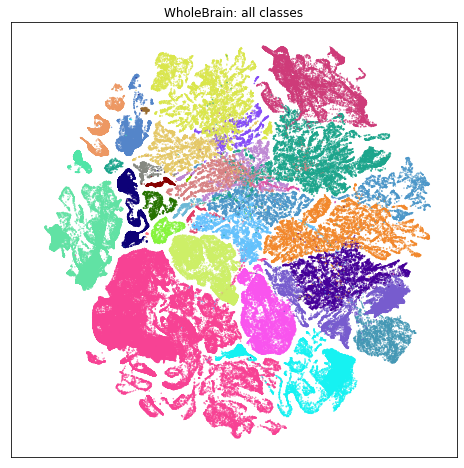

In [12]:
subsampled = joined_10x.loc[::10]
color = subsampled['class_color'].copy()
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=color)
res = ax.set_title('WholeBrain: all classes')

We filter to only colorized cells in the HY-EA cluster group to visualize cell type classes, subclasses and neurotransmitter types

The hypothalamus and extended amygdala (HY-EA) neuronal type taxonomy containing 6 classes (CNU-HYa GABA, HY GABA, CNU-HYa Glut, HY Glut, HY MM Glut, HY Gnrh1 Glut; 1,388 clusters)


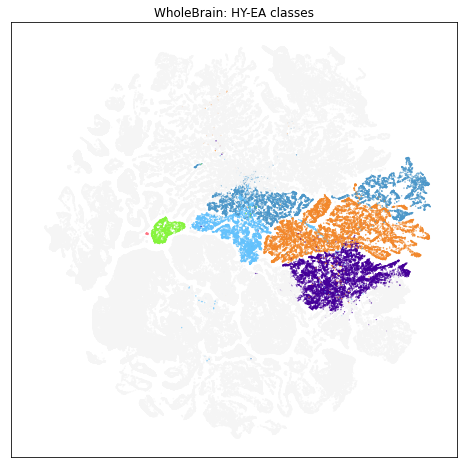

In [13]:
glabel = "CCN20230504_HY-EA"
print(groups.loc[glabel,'description'])
gname = groups.loc[glabel,'name']
pred = (subsampled[gname] == False)

color = subsampled['class_color'].copy()
color[pred] = '#f5f5f5'
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=color)
res = ax.set_title('WholeBrain: HY-EA classes')

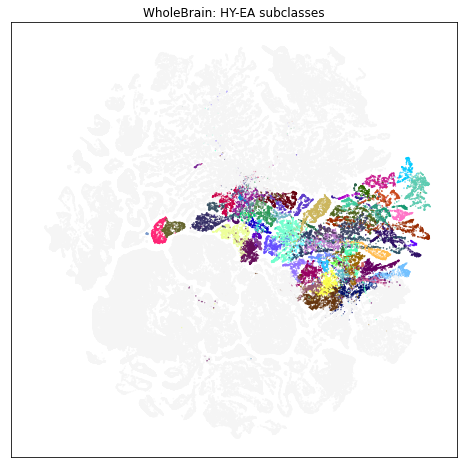

In [14]:
color = subsampled['subclass_color'].copy()
color[pred] = '#f5f5f5'
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=color)
res = ax.set_title('WholeBrain: HY-EA subclasses')

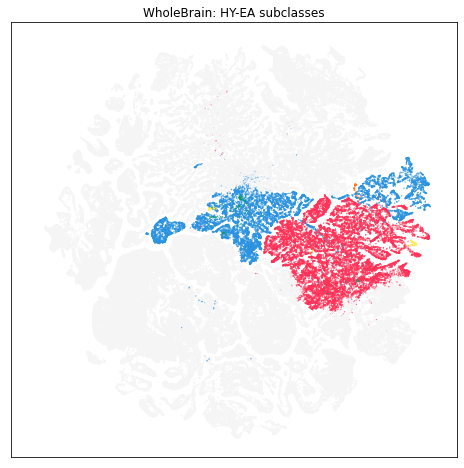

In [15]:
color = subsampled['neurotransmitter_color'].copy()
color[pred] = '#f5f5f5'
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=color)
res = ax.set_title('WholeBrain: HY-EA subclasses')

In this next section, we read in the coordinates for the HY-EA specific embedding

In [16]:
maps_by_group = maps.set_index('cluster_group_label')
mlabel = maps_by_group.loc[glabel,'label']

metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata[mlabel]['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
coord = pd.read_csv(file)
coord.set_index('cell_label',inplace=True)

We create a new dataframe "neighborhoos" by joining the spatial coordinates with cell metadata

In [17]:
neighborhood = coord.join( joined_10x, how='left', rsuffix='orig')

We can resuse the same plot umap helper function to visualize cell type classes, subclasses and neurotransmitter types in the new embedding

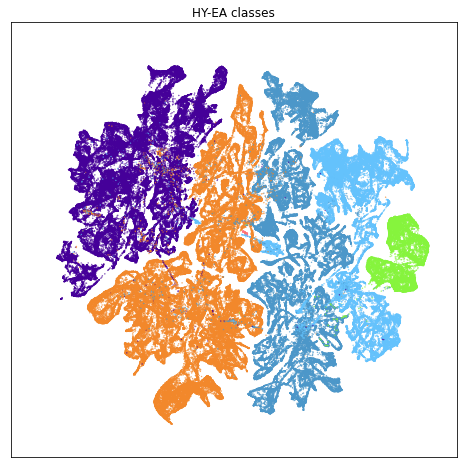

In [18]:
fig, ax = plot_umap(neighborhood['x'], neighborhood['y'],cc=neighborhood['class_color'])
res = ax.set_title('HY-EA classes')

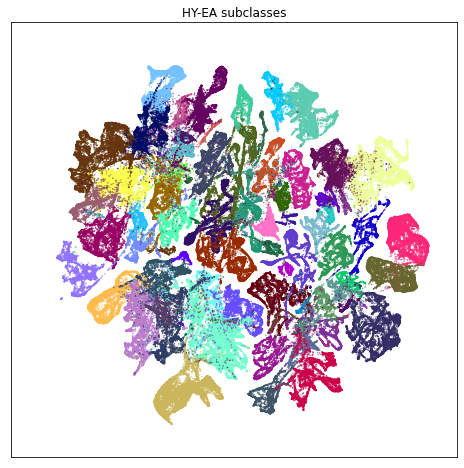

In [19]:
fig, ax = plot_umap(neighborhood['x'], neighborhood['y'],cc=neighborhood['subclass_color'])
res = ax.set_title('HY-EA subclasses')

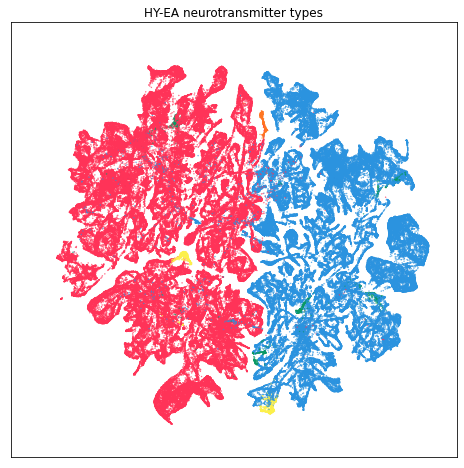

In [20]:
fig, ax = plot_umap(neighborhood['x'], neighborhood['y'],cc=neighborhood['neurotransmitter_color'])
res = ax.set_title('HY-EA neurotransmitter types')

### Visualize gene expression in neighborhood embedings

In this section, we show how to visualize gene expression in a neighborhood specific embedding. We start by reading in the gene expression dataframe we previously cached in the metadata directory from running 10x part 2a tutorial.

In [21]:
metadata = manifest['file_listing']['WMB-10X']['metadata']
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
print(exp.columns)

Index(['Slc32a1', 'Slc17a7', 'Slc6a5', 'Slc17a6', 'Slc6a2', 'Slc17a8', 'Tac2',
       'Slc6a4', 'Slc6a3', 'Slc18a3'],
      dtype='object')


We create a new dataframe "neighborhood_exp" that joins the neighborhood with gene expression information. We resuse the plot umap helper function to plot expression for genes Slc32a1 (GABAergic enriched) and Slc17ab (Glutamergic enriched).

In [22]:
neighborhood_exp = neighborhood.join(exp)

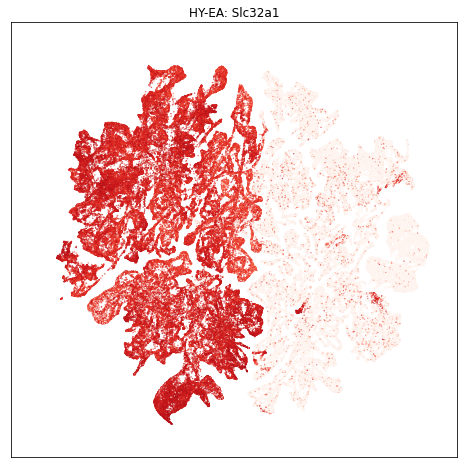

In [23]:
gene = 'Slc32a1'
fig, ax = plot_umap(neighborhood_exp['x'], neighborhood_exp['y'],val=neighborhood_exp[gene],cmap='Reds')
res = ax.set_title('HY-EA: %s' % gene )

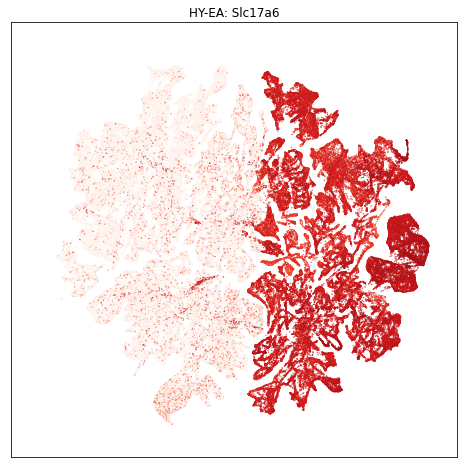

In [24]:
gene = 'Slc17a6'
fig, ax = plot_umap(neighborhood_exp['x'], neighborhood_exp['y'],val=neighborhood_exp[gene],cmap='Reds')
res = ax.set_title('HY-EA: %s' % gene )

### Visualize cluster groups in anatomical context

In this section, we visualize a cluster group in anatomical context using the whole brain merfish dataset. We begin by reading in the extended cell metadata dataframe.

In [25]:
metadata = manifest['file_listing']['MERFISH-C57BL6J-638850']['metadata']
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cell = pd.read_csv(file,dtype={"cell_label":str})
cell.set_index('cell_label',inplace=True)

We join with cluster membership pivot table to get cell to cluster group member. For convenience, we can cache this view for later reuse.

In [26]:
joined_merfish = cell.join(pivot,on='cluster_alias')

if cache_views :
    
    file = os.path.join( view_directory, 'merfish_cell_metadata_with_group_membership.csv')
    joined_merfish.to_csv( file )

We create a helper function to visualized a set of brain sections, colorized by specified cell property and filtered to a user specified cluster group.

In [27]:
def plot_sections( df, group, feature, blist, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist) :
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x']
        yy = filtered['y']

        vv = filtered[feature].copy()
        pred = (filtered[group] == False)
        vv[pred] = '#f5f5f5'
        
        ax[idx].scatter(xx,yy,s=1.0,color=vv,marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0,11)
        ax[idx].set_ylim(11,0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s: %s" % (group,bsl) )
        
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()
    return fig, ax

We use the helper function to view 6 MERFISH sections, colorized by cell type subclass and restricted to HY-EA subgroup.

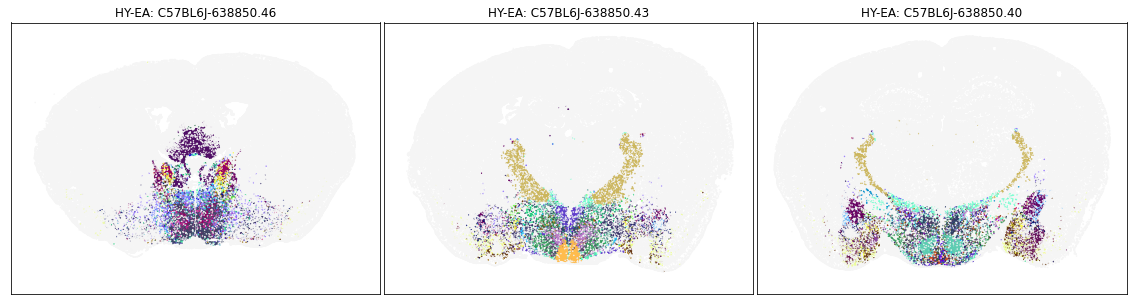

In [28]:
blist = ['C57BL6J-638850.46','C57BL6J-638850.43','C57BL6J-638850.40']
fig, ax = plot_sections( joined_merfish, 'HY-EA', 'subclass_color', blist )

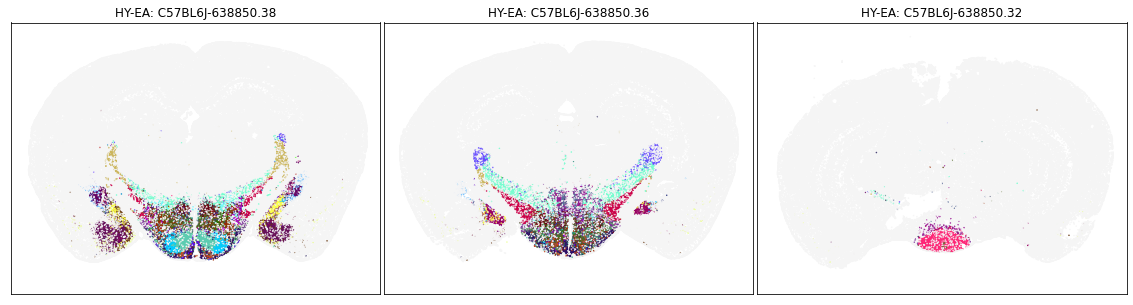

In [29]:
blist = ['C57BL6J-638850.38','C57BL6J-638850.36','C57BL6J-638850.32']
fig, ax = plot_sections( joined_merfish, 'HY-EA', 'subclass_color', blist )